In [1]:
# for Cal OEHHA Climate report
# OISST Trends
# data acquired in the cloud (chelle updated the data for me)

In [93]:
import matplotlib as plt
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import scipy.stats as stat
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import statsmodels.api as sm
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.feature as cfeature

import warnings
warnings.simplefilter('ignore') #filter some warning messages

In [8]:
ds = xr.open_dataset('./coastal_annual_OISST_1982-2019.nc')
ds.close()
ds

<xarray.Dataset>
Dimensions:  (point: 60, time: 38)
Coordinates:
  * point    (point) int64 0 1 2 3 4 5 6 7 8 9 ... 50 51 52 53 54 55 56 57 58 59
  * time     (time) int64 1982 1983 1984 1985 1986 ... 2015 2016 2017 2018 2019
Data variables:
    SST      (time, point) float64 ...
    Lon      (point) float64 ...
    Lat      (point) float64 ...

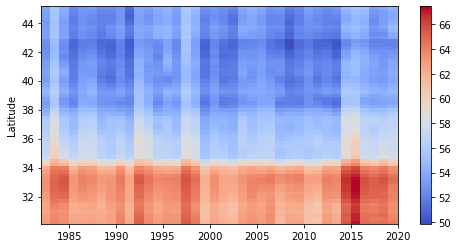

In [30]:
yrs = np.full((len(ds.time)+1),np.nan)
yrs[:-1] = ds.time.values
yrs[-1] = yrs[-2]+1

lats = np.full((len(ds.Lat)+1),np.nan)
lats[:-1] = ds.Lat.values
lats[-1] = lats[-2]+0.25

SST = np.full((len(yrs),len(lats)),np.nan)
SST[:-1,:-1]=ds.SST.values

SST = (SST * 9/5) + 32

plt.figure(figsize=(8,4))
plt.pcolormesh(yrs, lats, SST.transpose(), cmap='coolwarm')
plt.colorbar()
plt.ylabel('Latitude')
#plt.savefig('../figures/NorCalbullkelp_hovmuller.png')
plt.show()

In [22]:
def calculate_trend(x,y,iy,fy):
    # first degree polynomial
    polf = PolynomialFeatures(1)
    # select years
    a = (x>=iy) & (x<=fy)
    x = x[a]
    y = y[a]
    
    # get rid of nan years
    a = ~np.isnan(y)
    y2=y[a]
    x2=x[a]
    y2 = y2.reshape(-1, 1)
    x2 = x2.reshape(-1, 1)

    # calculate years
    xp = polf.fit_transform(x2)
    mods2 = sm.OLS(y2,xp).fit()
    trend = mods2.params[1]*10
    p_tr = mods2.pvalues[1]

    return trend, p_tr, x2[0][0], x2[-1][0]

In [31]:
SST_tr = np.full((len(ds.Lat)),np.nan)
tr_p = np.full((len(ds.Lat)),np.nan) 
years = ds.time.values
sst = (ds.SST * 9/5) + 32
for i in range(len(ds.Lat)):
    SST_tr[i], tr_p[i], iy, fy = calculate_trend(years,sst[:,i].values, years[0],years[-1])


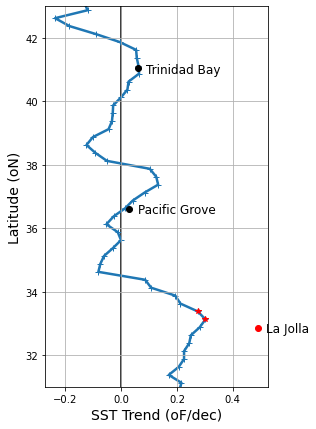

In [126]:
ssp_lats = [32+52/60,36+37.3/60,41+03.3/60] # La Jolla, Pacific G, Trinidad
ssp_trs = [0.49,0.03,0.06]
ssp_p = [True, False, False]
ssp_lab = ['La Jolla','Pacific Grove','Trinidad Bay']

plt.figure(figsize=(4,7))
plt.plot(SST_tr, ds.Lat.values, '+-', c='tab:blue', lw=2.5, zorder=1)
a=tr_p<=0.1
plt.plot(SST_tr[a], ds.Lat.values[a],'r*', zorder=2)
for i in range(3):
    if ssp_p[i]:
        plt.plot(ssp_trs[i],ssp_lats[i],'ro')
    else:
        plt.plot(ssp_trs[i],ssp_lats[i],'ko')
    plt.text(ssp_trs[i]+0.03,ssp_lats[i]-0.15,ssp_lab[i], fontsize=12)
plt.axvline(c='k', zorder=0)
plt.ylim([31,43])
plt.grid()
plt.ylabel('Latitude (oN)',fontsize=14)
plt.xlabel('SST Trend (oF/dec)', fontsize=14)
plt.show()

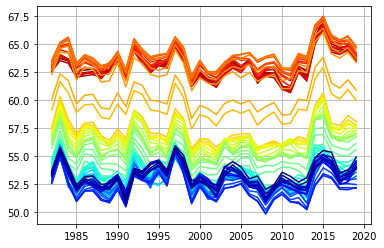

In [56]:
n = len(ds.Lat)
colors = plt.cm.jet_r(np.linspace(0,1,n))
for ii,i in enumerate(ds.Lat.values):
    plt.plot(years,sst[:,ii],color=colors[ii])
plt.grid(zorder=0)
plt.show()

In [79]:
# near la jolla
SST_tr.max()

0.3018031843982494

In [83]:
ssp_lats

[32.86666666666667, 36.62166666666667, 41.055]

In [82]:
lats

array([30.125, 30.375, 30.625, 30.875, 31.125, 31.375, 31.625, 31.875,
       32.125, 32.375, 32.625, 32.875, 33.125, 33.375, 33.625, 33.875,
       34.125, 34.375, 34.625, 34.875, 35.125, 35.375, 35.625, 35.875,
       36.125, 36.375, 36.625, 36.875, 37.125, 37.375, 37.625, 37.875,
       38.125, 38.375, 38.625, 38.875, 39.125, 39.375, 39.625, 39.875,
       40.125, 40.375, 40.625, 40.875, 41.125, 41.375, 41.625, 41.875,
       42.125, 42.375, 42.625, 42.875, 43.125, 43.375, 43.625, 43.875,
       44.125, 44.375, 44.625, 44.875, 45.125])

In [90]:
a = lats[:-1]==32.875
SST_tr[a]

array([0.281178])

In [91]:
a = lats[:-1]==36.625
SST_tr[a]

array([0.01373444])

In [92]:
a = lats[:-1]==41.125
SST_tr[a]

array([0.06208583])

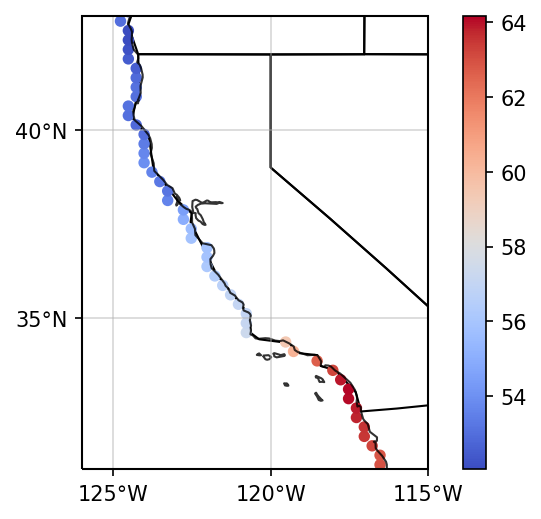

In [113]:
msst=SST
fig=plt.figure(figsize=(6,4),dpi=150)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(resolution='50m',linewidth=1,color='black',alpha=0.8,zorder=1)
ax.add_feature(cfeature.STATES, zorder=0)
ax.set_extent([-126,-115,31,43],crs=ccrs.PlateCarree())
ax.set_xticks([-125,-120,-115], crs=ccrs.PlateCarree())
ax.set_yticks([35,40], crs=ccrs.PlateCarree())
ax.xaxis.set_major_formatter(LongitudeFormatter(zero_direction_label=True))
ax.yaxis.set_major_formatter(LatitudeFormatter())
plt.scatter(ds.Lon-0.15, ds.Lat, 20, sst.mean(dim='time').values,'o', cmap='coolwarm')
plt.grid(True, zorder=0,alpha=0.5)
plt.colorbar()
ax.set_aspect(1.2)
#fig.savefig('../figures/map_base.png')
plt.show()


In [118]:
# global trends
gds = xr.open_dataset('global_OISST_1982-2019.nc')
gsst = (gds.sst * 9/5) + 32
gds.close()
gsst

<xarray.DataArray 'sst' (time: 38)>
array([56.18345 , 56.330406, 56.222523, 56.099693, 56.1414  , 56.32009 ,
       56.28747 , 56.215115, 56.387863, 56.372383, 56.284214, 56.31314 ,
       56.30961 , 56.421276, 56.28818 , 56.506012, 56.576317, 56.293465,
       56.364098, 56.569202, 56.602196, 56.702583, 56.620422, 56.774364,
       56.723274, 56.672382, 56.61002 , 56.724434, 56.75552 , 56.624863,
       56.732967, 56.767044, 56.906002, 57.030155, 57.0924  , 57.030937,
       56.943546, 57.06182 ], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1982-01-01 1983-01-01 ... 2019-01-01
    zlev     float32 ...

In [119]:
gtr, gtr_p, iy, fy = calculate_trend(years,gsst.values, years[0],years[-1])
print(gtr, gtr_p)

0.23643218997479953 5.852685240018479e-18


In [120]:
gtr, gtr_p, iy, fy = calculate_trend(years,gsst.values, 2000, 2016)
print(gtr, gtr_p)

0.2773638332591366 6.831348594987865e-05
